<div style="text-align: center;">
    <img src="image.png" alt="logo" width="600">
</div>


# Context

L’Organisation nationale de lutte contre le faux-monnayage, ou ONCFM,est une organisation publique ayant pour objectif de mettre en place desméthodes d’identification des contrefaçons des billets en euros. <br> 
Dans le cadre de cette lutte, nous souhaitons mettre en place un algorithme quisoit capable de différencier automatiquement les vrais des faux billets.

# Objectif 

Construire un algorithme qui, à partir des caractéristiques
géométriques d’un billet, serait capable de définir si ce dernier est un vrai
ou un faux billet.

# Libraries

In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
import sklearn
import statsmodels
import pickle
sns.set()

# Data preparation

In [89]:
billets = pd.read_csv("billets.csv",delimiter=";")

In [90]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


Les données du dataframe :
- diagonal : la diagonale du billet (en mm)
- height_left : la hauteur du billet (mesurée sur le côté gauche, en mm)
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm)
- margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm)
- margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm)
- length : la longueur du billet (en mm)

In [91]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [92]:
billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

**Attention** 37 valeurs manquantes sur margin_low

In [93]:
billets.duplicated().sum()


0

is_genuine
True     1000
False     500
Name: count, dtype: int64


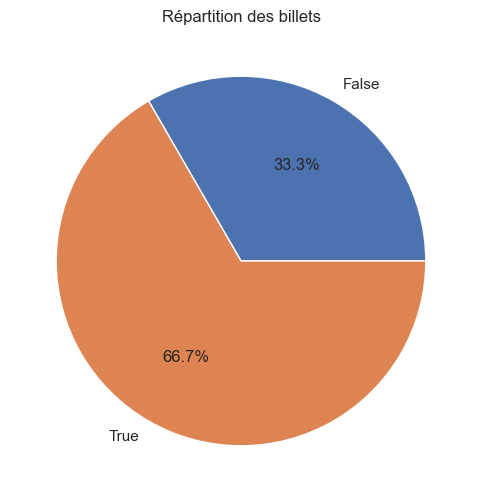

In [94]:
Nb_vrai_faux = billets['is_genuine'].value_counts()
print(Nb_vrai_faux)
plt.figure(figsize=(10, 6))

plt.pie(billets.groupby(["is_genuine"])["diagonal"].count(),
        labels=["False","True"],
        autopct="%1.1f%%")
plt.title("Répartition des billets")
plt.show()

Le dataframe est composé de 1000 vrais billets et 500 faux billets

In [95]:
diff_diag = (((billets.loc[billets["is_genuine"]==True]["diagonal"].mean())-(billets.loc[billets["is_genuine"]==False]["diagonal"].mean()))/(billets.loc[billets["is_genuine"]==True]["diagonal"].mean()))*100
diff_h_left = (((billets.loc[billets["is_genuine"]==True]["height_left"].mean())-(billets.loc[billets["is_genuine"]==False]["height_left"].mean()))/(billets.loc[billets["is_genuine"]==True]["height_left"].mean()))*100
diff_h_right = (((billets.loc[billets["is_genuine"]==True]["height_right"].mean())-(billets.loc[billets["is_genuine"]==False]["height_right"].mean()))/(billets.loc[billets["is_genuine"]==True]["height_right"].mean()))*100
diff_m_low = (((billets.loc[billets["is_genuine"]==True]["margin_low"].mean())-(billets.loc[billets["is_genuine"]==False]["margin_low"].mean()))/(billets.loc[billets["is_genuine"]==True]["margin_low"].mean()))*100
diff_m_up = (((billets.loc[billets["is_genuine"]==True]["margin_up"].mean())-(billets.loc[billets["is_genuine"]==False]["margin_up"].mean()))/(billets.loc[billets["is_genuine"]==True]["margin_up"].mean()))*100
diff_length = (((billets.loc[billets["is_genuine"]==True]["length"].mean())-(billets.loc[billets["is_genuine"]==False]["length"].mean()))/(billets.loc[billets["is_genuine"]==True]["length"].mean()))*100

pd.DataFrame(index=["Moyenne des écrats en %"],columns=["diagonale","height_left","height_right","margin_low","margin_up","length"],data=[[diff_diag, diff_h_left, diff_h_right, diff_m_low, diff_m_up, diff_length]])

,diagonale,height_left,height_right,margin_low,margin_up,length
Moyenne des écrats en %,0.049957,-0.232046,-0.32268,-26.720415,-9.764656,1.388477


On observe un écart significatif entre les mesures des vrais et des faux billets 

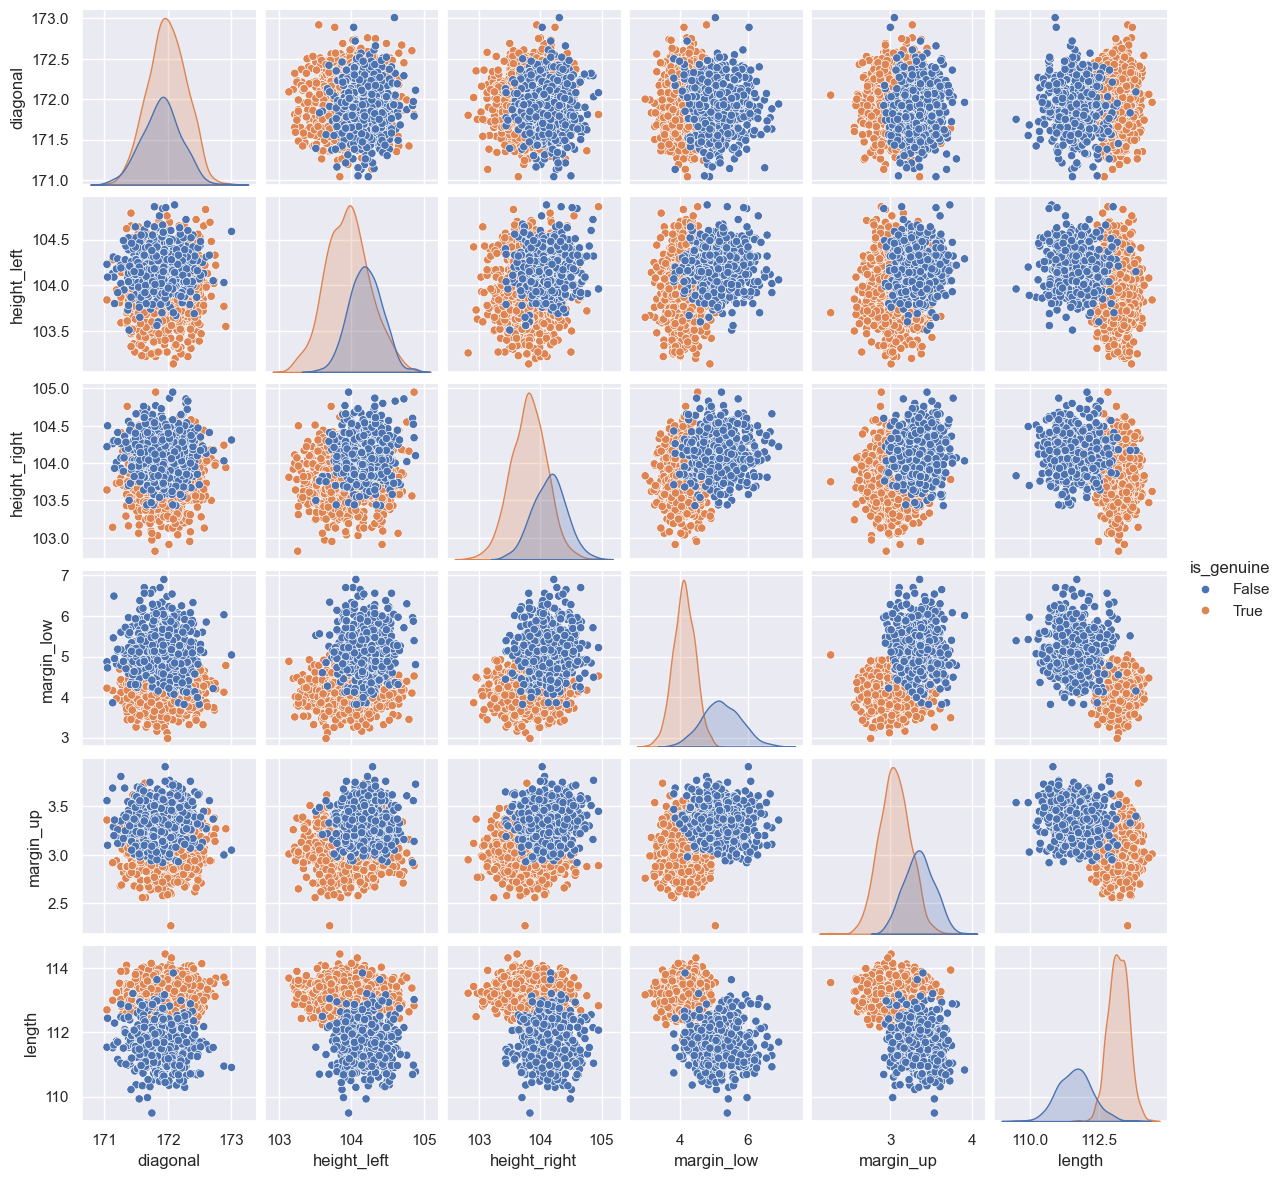

In [133]:
sns.pairplot(billets, hue='is_genuine', height=2)



On observe ici une nouvelle fois les écarts entre les vrais billets et les faux

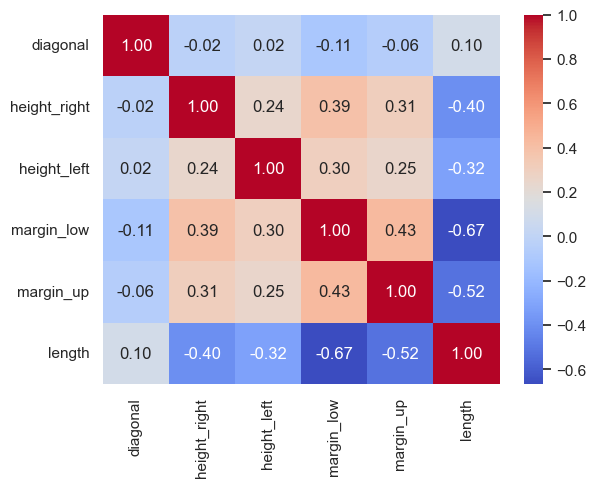

In [97]:
df_quanti = billets[['diagonal','height_right', 'height_left','margin_low', 'margin_up', 'length']]
corr = df_quanti.corr() 
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

Dans cette matrice ce correlation on observe un lien entre margin_low et length ainsi qu'avec margin_up et lenght

# Remplacement des valeurs manquantes 

## Regression linéaire multiple

La régression linéaire multiple est une méthode statistique utilisée pour modéliser la relation entre une variable dépendante (ou variable à expliquer) et plusieurs variables indépendantes (ou variables explicatives)


Ici la regression linéaire va servir a prédire les valeurs manquante de margin_low du dataframe en s'appuyant sur les autres variables.

In [98]:
margin_low = smf.ols('margin_low ~ diagonal+height_left+height_right+margin_up+length', data=billets).fit()
print(margin_low.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Tue, 09 Jul 2024   Prob (F-statistic):          2.60e-202
Time:                        15:49:50   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

toutes les p-values sont inférieurs à 5%, les variables sont toutes significatives.

Le coeficient de détermination R² vaut 0,477 tout comme le R² ajusté. Pour rappel, R² vaut entre 0 et 1:

- si R² vaut 1, cela signifie que toute la variable est expliquée par le modèle
- si R² vaut 0, au contraire aucune variable n'est expliquée par le modèle.

## Colinéarité des variables

Vérifier la colinéarité dans une régression linéaire multiple est essentiel pour garantir la robustesse, la précision et l'interprétabilité des résultats obtenus.

Calcul des facteurs d'inflation de la variance (VIF)

In [99]:
variables = margin_low.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0136128990686304,
 1.138260573608248,
 1.2301145155560362,
 1.4044037781843606,
 1.576950145366583]

VIF ≈ 1 : Pas de multicolinéarité. La variable n'est pas colinéaire avec les autres. <br>
1 < VIF < 5 : Modérée multicolinéarité. Généralement acceptable, mais peut nécessiter une attention.<br>
VIF ≥ 5 : Forte multicolinéarité. Souvent considéré comme problématique, nécessitant une investigation et potentiellement une action pour corriger la colinéarité (par exemple, en supprimant ou en combinant des variables).

Aucune des variables ne présente de VIF supérieur à 5, donc il n'y a pas de forte multicolinéarité détectée. Cela suggère que les variables indépendantes du modèle ne sont pas fortement colinéaires et que les coefficients de régression devraient être relativeme stables

## L'homoscédasticité

Vérifier l'homoscédasticité dans le contexte d'une régression linéaire multiple est essentiel pour s'assurer que les résidus du modèle présentent une dispersion constante à travers les différentes valeurs prédites de la variable dépendante. En d'autres termes, cela signifie que la variance des erreurs résiduelles est constante pour toutes les valeurs de la variable prédite.

2 hypothése sont ici testé

- H0 : homoscédasticité des résidus
- H1 : hétéroscédascité des résidus

In [100]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(margin_low.resid, variables)
print('P-value test Breusch Pagan:', pval)

P-value test Breusch Pagan: 7.759535216151227e-16


La P-value du test Breusch Pagan est inférieure a 5%. L'hypothèse H0 est donc rejeté.

In [135]:
shapiro(margin_low.resid)

ShapiroResult(statistic=0.9857882577573781, pvalue=8.540407842392184e-11)

P-value < 5%, les résultats obtenus ne sont pas absurde sachat que le dataframe est de taille suffisante

## Prédiction des valeurs manquantes avec la regression linéaire multiple

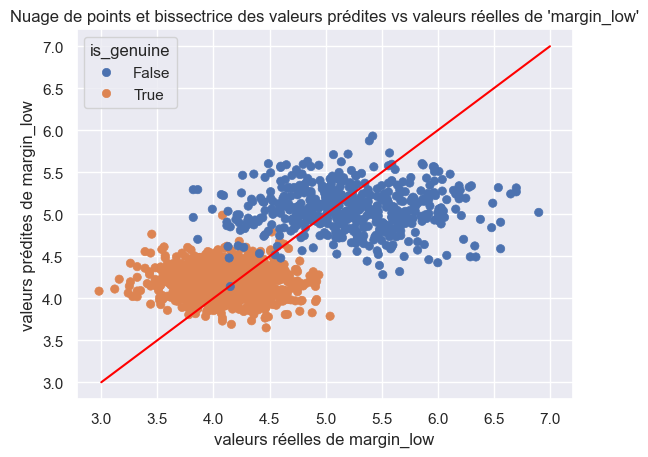

In [101]:
margin_low_lin= margin_low.predict(billets)
df_margin_low_lin=pd.DataFrame(margin_low_lin)
df_merge=pd.merge(df_margin_low_lin,billets, left_index=True, right_index=True, how='right')
df_merge.rename(columns={0:'margin_low_pred'}, inplace=True)


sns.scatterplot(x='margin_low', y='margin_low_pred', data=df_merge, hue='is_genuine', ec=None)
plt.plot([3,7],[3,7], c='red')

plt.xlabel("valeurs réelles de margin_low")
plt.ylabel("valeurs prédites de margin_low")
plt.title ("Nuage de points et bissectrice des valeurs prédites vs valeurs réelles de 'margin_low'")
plt.show()


In [102]:
df_merge.loc[df_merge['margin_low'].isna(),'margin_low']=df_merge['margin_low_pred']
df_cleaned=df_merge.drop('margin_low_pred', axis=1)

In [103]:
df_cleaned.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

## Test de Student sur les variables 

le test de Student est un outil statistique essentiel pour comparer des moyennes et évaluer l'importance des différences observées dans des études comparatives, en tenant compte de la variabilité et de la taille des échantillons.

In [104]:
true_bills = df_cleaned[df_cleaned["is_genuine"]==True]
false_bills = df_cleaned[df_cleaned["is_genuine"]==False]
columns = ["diagonal", "height_left", "height_right","margin_low","margin_up","length"]
resultats = {}
for column in columns:
    t_stat, p_value = ttest_ind(true_bills[column], false_bills[column], equal_var=False)
    resultats[column] = {'t_stat': t_stat, 'p_value': p_value}

for colonne, stats in resultats.items():
    print(f"Colonne: {colonne}")
    print(f"  t_stat: {stats['t_stat']}")
    print(f"  p_value: {stats['p_value']}")
    if stats['p_value'] < 0.05: 
        print("  -> Différence significative entre les vrais et faux billets")
    else:
        print("  -> Pas de différence significative entre les vrais et faux billets")


Colonne: diagonal
  t_stat: 5.1476583157923645
  p_value: 3.1869002032029505e-07
  -> Différence significative entre les vrais et faux billets
Colonne: height_left
  t_stat: -17.48660281591907
  p_value: 1.415362997565114e-61
  -> Différence significative entre les vrais et faux billets
Colonne: height_right
  t_stat: -22.003138347860016
  p_value: 9.28759361609604e-89
  -> Différence significative entre les vrais et faux billets
Colonne: margin_low
  t_stat: -41.22587929536443
  p_value: 6.548534980340679e-186
  -> Différence significative entre les vrais et faux billets
Colonne: margin_up
  t_stat: -29.820666146692975
  p_value: 2.9274009689336744e-141
  -> Différence significative entre les vrais et faux billets
Colonne: length
  t_stat: 52.77360271974255
  p_value: 1.4699545634381945e-241
  -> Différence significative entre les vrais et faux billets


Pour toutes les colonnes testées (diagonal, height_left, height_right, margin_low, margin_up, length), les p-values sont extrêmement faibles, indiquant des différences significatives entre les vrais et faux billets. Les valeurs t positives ou négatives vous indiquent si les moyennes des vrais billets sont respectivement plus grandes ou plus petites que celles des faux billets pour chaque mesure.

Ces résultats suggèrent que toutes les caractéristiques mesurées permettent de distinguer de manière significative les vrais billets des faux billets.

# Regression logistique

La régression logistique est une technique statistique utilisée pour prédire la probabilité d'un événement binaire (ici True/False) en fonction d'un ensemble de variables explicatives. Elle utilise une fonction logistique pour modéliser la relation entre les variables indépendantes et la probabilité de l'événement, compressant les prédictions dans un intervalle de 0 à 1. Les coefficients de régression logistique quantifient l'impact des variables explicatives sur la probabilité de l'événement, facilitant ainsi l'interprétation et la prise de décision dans divers domaines.

Création de 2 dataframes a partir du fichiers fournis pour avoir un fichier d'entrainement et un fichier de test

In [105]:
df_cleaned_true = df_cleaned.loc[df_cleaned["is_genuine"]==True]
train_df_true, test_df_true = train_test_split(df_cleaned_true,test_size=0.25,train_size=0.75)
df_cleaned_false = df_cleaned.loc[df_cleaned["is_genuine"]==False]
train_df_false, test_df_flase = train_test_split(df_cleaned_false,test_size=0.25,train_size=0.75)

train_df = pd.concat([train_df_true,train_df_false])
test_df = pd.concat([test_df_true,test_df_flase])

In [106]:
train_df.shape

(1125, 7)

In [107]:
test_df.shape

(375, 7)

Premiere itération de regression logistique

In [108]:
reg_log1 = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length', data=train_df, family=sm.families.Binomial()).fit()

print(reg_log1.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1125
Model:                                                   GLM   Df Residuals:                     1118
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -33.219
Date:                                       Tue, 09 Jul 2024   Deviance:                       66.439
Time:                                               15:49:50   Pearson chi2:                 1.29e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7030
Covariance Type:                                   nonrobust                      

On voit que la P value de la variable digonal est superieur à 5% donc il faut l'enlever du modèle pour augmenter la précision

Retirer les variables avec une p-value supérieure à 5 % et effectuer plusieurs itérations permet d'obtenir un modèle logistique qui est non seulement statistiquement significatif mais aussi plus simple, plus performant et plus fiable.

Deuxieme itération de regression logistique

In [109]:
reg_log1 = smf.glm('is_genuine~+height_left+height_right+margin_low+margin_up+length', data=train_df, family=sm.families.Binomial()).fit()

print(reg_log1.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1125
Model:                                                   GLM   Df Residuals:                     1119
Model Family:                                       Binomial   Df Model:                            5
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -33.458
Date:                                       Tue, 09 Jul 2024   Deviance:                       66.915
Time:                                               15:49:50   Pearson chi2:                 1.23e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7029
Covariance Type:                                   nonrobust                      

On voit que la P value de la variable height_left est superieur à 5% donc il faut l'enlever du modèle pour augmenter la précision

Troisieme itération de regression logistique

In [110]:
reg_log1 = smf.glm('is_genuine~+height_right+margin_low+margin_up+length', data=train_df, family=sm.families.Binomial()).fit()
model = 'reg_model.sav'
pickle.dump(reg_log1,open(model,'wb'))
print(reg_log1.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1125
Model:                                                   GLM   Df Residuals:                     1120
Model Family:                                       Binomial   Df Model:                            4
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -35.742
Date:                                       Tue, 09 Jul 2024   Deviance:                       71.485
Time:                                               15:49:50   Pearson chi2:                 1.50e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7016
Covariance Type:                                   nonrobust                      

Toutes les P-values sont inférieurs à 5% donc le modèle de regression logistique est bon

## Test du modèle sur les données 

In [111]:
prediction_prob = reg_log1.predict(test_df)
prediction_log = prediction_prob.round(0)
prediction_log_df = pd.DataFrame({'type_pred_log': prediction_log, 'prob_pred_log': prediction_prob})
df_test_log = pd.merge(test_df, prediction_log_df, left_index=True, right_index=True, how='left')
df_test_log['bool_pred_log'] = ~df_test_log['type_pred_log'].astype(bool)
df_test_log


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,type_pred_log,prob_pred_log,bool_pred_log
157,True,171.88,104.04,104.08,3.800000,3.01,113.60,0.0,0.000005,True
205,True,172.16,104.04,104.02,4.060000,3.08,113.02,0.0,0.000882,True
705,True,172.46,103.75,104.02,4.260000,3.22,113.63,0.0,0.000447,True
803,True,171.87,103.27,104.50,3.850000,3.03,113.19,0.0,0.000195,True
297,True,172.12,103.90,104.32,3.830000,3.03,113.56,0.0,0.000016,True
...,...,...,...,...,...,...,...,...,...,...
1450,False,172.72,104.05,104.17,4.210000,3.37,111.53,1.0,0.994781,False
1310,False,171.92,104.84,104.60,5.960000,2.92,110.69,1.0,1.000000,False
1213,False,171.76,104.13,104.19,5.220000,3.55,111.90,1.0,0.999981,False
1074,False,172.14,104.49,103.76,4.360000,3.24,110.36,1.0,0.999957,False


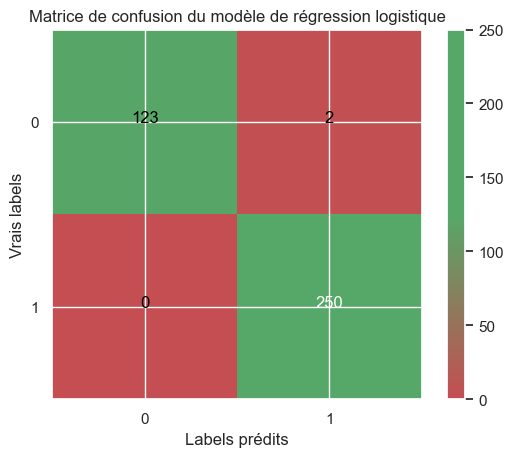

In [112]:
import itertools
from  matplotlib.colors import LinearSegmentedColormap
cnf_matrix = confusion_matrix(df_test_log['is_genuine'],df_test_log['bool_pred_log'])
classes = range(0,2)
plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap=LinearSegmentedColormap.from_list('rg',["r", "g", "g"], N=256))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.title('Matrice de confusion du modèle de régression logistique')
plt.show()

In [113]:

tn, fp, fn ,tp = cnf_matrix.reshape(-1)
print('le modèle de regression logistique appliqué au jeu de test prédit:')
print('- le nb de vrai positif est',tp)
print('- le nb de vrai négatif est',tn)
print('- le nb de faux positif est',fp)
print('- le nb de faux négatif est',fn)
erreur_log = ((fp+fn)*100/(fp+fn+tp+tn)).round(2)

print('==> le pourcentage d\'erreur de ce modèle est donc de', erreur_log,'%')

le modèle de regression logistique appliqué au jeu de test prédit:
- le nb de vrai positif est 250
- le nb de vrai négatif est 123
- le nb de faux positif est 2
- le nb de faux négatif est 0
==> le pourcentage d'erreur de ce modèle est donc de 0.53 %


# Kmeans

Les k-means sont une méthode de partitionnement utilisée en apprentissage non supervisé pour regrouper des données en k clusters, facilitant ainsi la classification des points de données selon leurs similarités. L'algorithme itère entre l'attribution des points aux clusters et la mise à jour des centroïdes jusqu'à ce que les clusters se stabilisent. Les k-means sont particulièrement utiles pour la classification dans des tâches telles que la segmentation de clients, l'organisation de documents ou l'analyse d'images.

In [114]:
train_df_kmeans = train_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
train_df_km = train_df.copy()
test_df_km = test_df
train_df_km

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
727,True,172.05,103.72,103.81,4.21,2.97,113.61
809,True,172.01,103.51,103.48,4.42,3.13,113.50
959,True,172.31,103.98,103.53,4.04,2.97,113.47
409,True,172.06,103.96,103.72,4.18,3.15,113.17
926,True,172.15,103.98,103.89,4.21,3.08,113.61
...,...,...,...,...,...,...,...
1278,False,172.11,104.23,104.45,5.24,3.58,111.78
1399,False,171.81,104.44,104.23,5.29,3.39,111.64
1247,False,171.57,104.04,104.14,5.27,3.42,112.68
1312,False,171.92,104.37,104.05,4.95,3.04,110.61


In [115]:
std_scale=preprocessing.StandardScaler().fit(train_df_kmeans)
X_scaled = std_scale.transform(train_df_kmeans)
pd.DataFrame(X_scaled).describe().round(2).iloc[1:3:, : ]

,0,1,2,3,4,5
mean,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


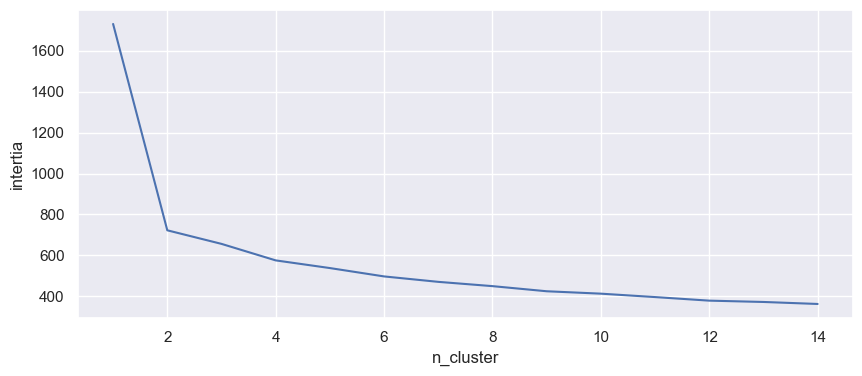

In [116]:
 
intertia_list = [ ]

k_list = range(1, 15)

for k in k_list : 
    
    kmeans = KMeans(n_clusters=k)
    
    kmeans.fit(train_df_kmeans)
    
    intertia_list.append(kmeans.inertia_)
    
fig, ax = plt.subplots(1,1,figsize=(10,4))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")

ax = plt.plot(k_list, intertia_list)

Ici 2 cluster vont etre choisis, premierement on peut voir sur le elbow plot une cassure a n_cluster = 2 et aussi nous cherchons a classer les vrais et faux billets


In [117]:
n_clust = 2
kmeans = KMeans(n_clust)
kmeans.fit(train_df_kmeans)
clusters_k2 = kmeans.labels_ 
centroids_k2 = kmeans.cluster_centers_ 
train_df_kmeans

,diagonal,height_left,height_right,margin_low,margin_up,length
727,172.05,103.72,103.81,4.21,2.97,113.61
809,172.01,103.51,103.48,4.42,3.13,113.50
959,172.31,103.98,103.53,4.04,2.97,113.47
409,172.06,103.96,103.72,4.18,3.15,113.17
926,172.15,103.98,103.89,4.21,3.08,113.61
...,...,...,...,...,...,...
1278,172.11,104.23,104.45,5.24,3.58,111.78
1399,171.81,104.44,104.23,5.29,3.39,111.64
1247,171.57,104.04,104.14,5.27,3.42,112.68
1312,171.92,104.37,104.05,4.95,3.04,110.61


In [118]:
train_df_km['clusters_k2']=clusters_k2 
df_ana_clusters_k2 =train_df_km.groupby(['clusters_k2','is_genuine'])['diagonal'].count().reset_index(name='nb')
print('voici le détail par cluster du nb de billets vrais et faux:')
df_ana_clusters_k2

voici le détail par cluster du nb de billets vrais et faux:


,clusters_k2,is_genuine,nb
0,0,False,19
1,0,True,748
2,1,False,356
3,1,True,2


In [119]:
max_nb_rows = df_ana_clusters_k2.loc[df_ana_clusters_k2.groupby('clusters_k2')['nb'].idxmax()]
result = max_nb_rows[['clusters_k2', 'is_genuine']]
result.rename(columns={"is_genuine":'is_genuine_result'}, inplace=True)
result


/var/folders/wk/zryh1bzj52n34pfvpy18h2mw0000gn/T/ipykernel_7283/2019166035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result.rename(columns={"is_genuine":'is_genuine_result'}, inplace=True)


,clusters_k2,is_genuine_result
1,0,True
2,1,False


In [120]:
test_df_km = test_df_km.reset_index(drop=True)


In [121]:
test_df = test_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
prediction_k2=kmeans.predict(test_df)
prediction_k2_df=pd.DataFrame(prediction_k2)
prediction_k2_df.rename(columns={0:'cluster_pred_k2'}, inplace=True)
prediction_k2_df


,cluster_pred_k2
0,0
1,0
2,0
3,0
4,0
...,...
370,1
371,1
372,1
373,1


In [122]:
test_df_km = test_df_km.reset_index(drop=True)


In [123]:
df_test_kmeans2=pd.merge(test_df_km, prediction_k2_df, left_index=True, right_index=True, how='left')
df_test_kmeans2 = pd.merge(df_test_kmeans2,result,left_on="cluster_pred_k2",right_on="clusters_k2",how="left")


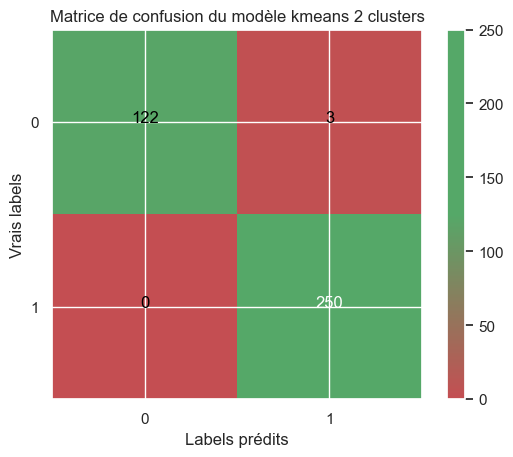

In [124]:
cnf_matrix_k2 = confusion_matrix(df_test_kmeans2['is_genuine'],df_test_kmeans2['is_genuine_result'])
classes = range(0,2)
plt.figure()

plt.imshow(cnf_matrix_k2, interpolation='nearest',cmap=LinearSegmentedColormap.from_list('rg',["r", "g", "g"], N=256))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix_k2.shape[0]), range(cnf_matrix_k2.shape[1])):
    plt.text(j, i, cnf_matrix_k2[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix_k2[i, j] > ( cnf_matrix_k2.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.title('Matrice de confusion du modèle kmeans 2 clusters')
plt.show()

In [125]:
tn_k2, fp_k2, fn_k2 ,tp_k2 = cnf_matrix_k2.reshape(-1)
print('le modèle de regression logistique appliqué au jeu de test prédit:')
print('- le nb de vrai positif est',tp_k2)
print('- le nb de vrai négatif est',tn_k2)
print('- le nb de faux positif est',fp_k2)
print('- le nb de faux négatif est',fn_k2)
#calcul % d'erreur
erreur_k2 = ((fp_k2+fn_k2)*100/(fp_k2+fn_k2+tp_k2+tn_k2)).round(2)

print('==> le pourcentage d\'erreur du modèle kmeans 2 clusters est donc de', erreur_k2,'%')

le modèle de regression logistique appliqué au jeu de test prédit:
- le nb de vrai positif est 250
- le nb de vrai négatif est 122
- le nb de faux positif est 3
- le nb de faux négatif est 0
==> le pourcentage d'erreur du modèle kmeans 2 clusters est donc de 0.8 %


In [126]:
print("Le pourcentage d'erreur sur la regression logistique est de ",erreur_log," %")

print("Le pourcentage d'erreur sur le Kmeans est de ",erreur_k2," %")

Le pourcentage d'erreur sur la regression logistique est de  0.53  %
Le pourcentage d'erreur sur le Kmeans est de  0.8  %


Le modèle regression logistique est celui dont le % d'erreur est le plus stable et le plus faible à chaque fois que j'ai fait tourné mon NB. C'est donc celui que nous allons utiliser pour le test de l'algorithme.

# Test sur les billets de production


## Regression logistique

In [127]:
loaded_model = pickle.load(open("reg_model.sav","rb"))
df_prod = pd.read_csv("billets_production.csv")
prediction_prob = loaded_model.predict(df_prod)
prediction_log = prediction_prob.round(0)
prediction_log_df = pd.DataFrame({'type_pred_log': prediction_log,'prob_pred_log': prediction_prob})
df_test_log = pd.merge(df_prod, prediction_log_df, left_index=True, right_index=True, how='left')
df_test_log['bool_pred_log'] = ~df_test_log['type_pred_log'].astype(bool)
df_test_log


,diagonal,height_left,height_right,margin_low,margin_up,length,id,type_pred_log,prob_pred_log,bool_pred_log
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,1.0,0.999904,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,1.0,0.999990,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,1.0,0.999950,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.0,0.003483,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.0,0.000026,True


In [128]:
nb = df_test_log['bool_pred_log'].value_counts()
nb = pd.DataFrame(nb)
print('Soit par type de billets:')
nb

Soit par type de billets:


,count
bool_pred_log,
False,3
True,2
